# Imports

In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab.data_table import DataTable
DataTable.max_columns = 400
import statsmodels.api as sm
import numpy as np
import json
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from torchvision import transforms, models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


# Set device and random seed


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# @title set seed and device
SEED = 31
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 31 has been set.
GPU is enabled in this notebook.


# Data Loaders

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/CIS 522/code/input/TikTok Data/fyp_1650166896697_with_virality.csv')
df = df.drop(columns=["Unnamed: 0"])
df

,id,caption_pp,author_verification,authorMeta.following,authorMeta.fans,authorMeta.heart,authorMeta.video,authorMeta.digg,music_original,musicMeta.duration,...,effect_Sticker su schermo verde,effect_Shapeshifting,effect_Vintage DV,effect_Mega Mouth,effect_Color Customizer,effect_Outline,effect_Color Selector,effect_Greenscreen,effect_Scrolling Text,label
0,6862153058223197445,18,1,589,89100000,2100000000,458,8327,0,10,...,0,0,0,0,0,0,0,0,0,0
1,6911406868699073798,69,1,99,11800000,233100000,193,27800,0,34,...,0,0,0,0,0,0,0,0,0,0
2,7028775404173413678,35,0,166,987000,40400000,3,8148,1,13,...,0,0,0,0,0,0,0,0,0,1
3,6975140587196517638,94,0,51,13300000,171800000,443,9341,1,24,...,0,0,0,0,0,0,0,0,0,0
4,6984473039605959941,24,0,9861,2900000,39000000,1093,15600,1,11,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,6889900644510059781,126,0,9948,1100000,13900000,263,55400,0,60,...,0,0,0,0,0,0,0,0,0,1
971,6814512525250530566,146,0,395,1600000,38400000,1025,74900,0,15,...,0,0,0,0,0,0,0,0,0,1
972,6983419881379155206,33,0,155,4400000,106700000,618,14600,1,91,...,0,0,0,0,0,0,0,0,0,0
973,6820442532665707782,46,1,376,9200000,223600000,600,353,1,10,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
class TikTokDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.input_size = (120*16,120*9)
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(self.input_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df['id'])

    def __getitem__(self, idx):
        image_folder = "/content/drive/Shareddrives/CIS 522/code/input/TikTok Data/batch_4_100000/"
        image = Image.open("{}/{}.png".format(image_folder, self.df.loc[idx]['id'])).convert('RGB')
        img = self.transform(image)
        label = self.df.loc[idx]['label']
        return img, label

In [ ]:
test_size = 0.2
train_df = df.sample(frac=1-test_size)
test_df = df.drop(train_df.index)
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)

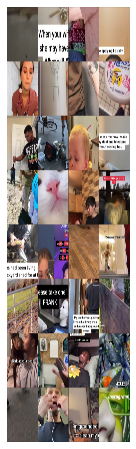

In [ ]:
# To preserve reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
batch_size = 32

# Load data
train_loader = DataLoader(TikTokDataset(train_df),
                          num_workers=0, 
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed)
test_loader = DataLoader(TikTokDataset(test_df), 
                         num_workers=0, 
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# Show images
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# Train
def train(model, optimizer, train_loader,
                          loss_fn, device, num_epochs=5):
  """
  Training loop

  Args:
    model: nn.module
      Untrained model
    optimizer: function
      Optimizer
    train_loader: torch.loader
      Training loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    model: nn.module
      Trained model
    train_loss: List(float)
      List of train losses at each epoch
    train_acc: List(float)
      List of train accuracies at each epoch
  """
  train_loss = []
  train_acc = []

  for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    # Set model to use the classifier head
    model.train()
    # Train on a batch of images
    
    running_loss = []
    running_acc = []

    for batch in train_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      optimizer.zero_grad()
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data, 1)

      running_loss.append(loss.item())
      running_acc.append((predicted == labels).sum().item()/labels.size(0))

    train_loss.append(np.mean(running_loss))
    train_acc.append(np.mean(running_acc))

  return model, train_loss, train_acc

In [ ]:
# Evalute
def eval(model, test_loader, loss_fn, device, num_epochs=5):
  """
  Evaluation loop

  Args:
    model: nn.module
      Untrained model
    test_loader: torch.loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    test_loss: List(float)
      List of test losses at each epoch
    test_acc: List(float)
      List of test accuracies at each epoch
  """

  test_loss = []
  test_acc = []

  for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    # Set model to use the classifier head
    model.eval()

    # Evaluate model on a batch of images
    running_loss = []
    running_acc = []

    for batch in test_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = loss_fn(outputs, labels)
      
      _, predicted = torch.max(outputs.data, 1)
      
      running_loss.append(loss.item())
      running_acc.append((predicted == labels).sum().item()/labels.size(0))

    test_loss.append(np.mean(running_loss))
    test_acc.append(np.mean(running_acc))

  return test_loss, test_acc

In [ ]:
# Pretrained resnet
resnet = models.resnet50(progress=True, pretrained=True).to(DEVICE)
resnet.fc = nn.Sequential(nn.Linear(2048, 128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128, 2)).to(DEVICE)
resnet_opt = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train on TikTok dataset
resnet_trained, train_loss, train_acc = train(
    resnet, resnet_opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)

# Evaluate
test_loss, test_acc = eval(
    resnet_trained, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

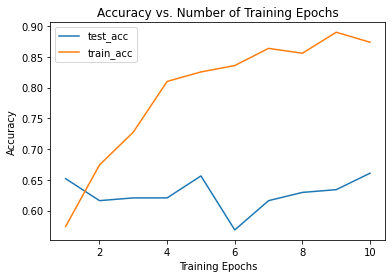

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("resnet", "acc"))
plt.show()

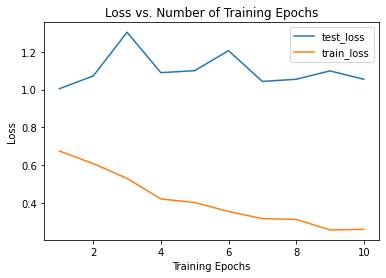

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("resnet", "loss"))
plt.show()

# CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.pool2 = nn.MaxPool2d(4, 4)
        
        self.drop_out = nn.Dropout(0.3)

        self.fc1 = nn.Linear(14848, 10024)
        self.fc2 = nn.Linear(10024, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop_out(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
cnn = Net().to(DEVICE)
cnn_opt = torch.optim.Adam(cnn.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train on TikTok dataset
cnn_trained, train_loss, train_acc = train(
    cnn, cnn_opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)

# Evaluate
test_loss, test_acc = eval(
    cnn_trained, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

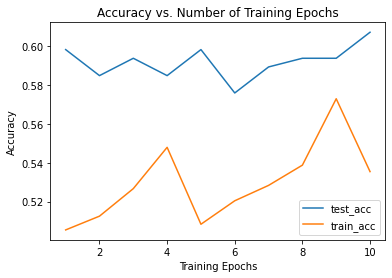

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("cnn", "acc"))
plt.show()

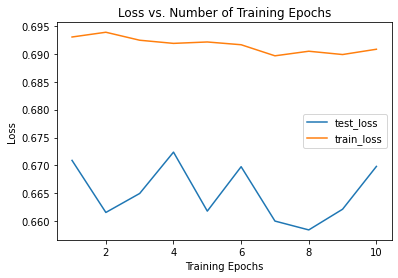

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("cnn", "loss"))
plt.show()